# CNN

In [1]:
import tensorflow.keras as keras

In [2]:
# Módulos necesarios. Asegurarse de poder importarlos.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import os as os
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from time import time

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [4]:
keras.__version__

'2.2.4-tf'

# 10-FOLD

In [5]:
subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
global activities
activities = [9,10,11,12,13,19,20,21,24,25,31]

In [6]:
# Ajustado a los datos
n_time_steps = 128
n_classes = 11 # Nº de clases (el 0 está eliminado)
n_channels = 1 # Nº de canales
n_columns = 40

# Podríamos variarlo
batch_size = 128 # Tamaño del batch
learning_rate = 1e-3 # Learning rate (por defecto es 0.001)
epochs = 100 # Épocas

In [7]:
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each correRPonding
        # epoch
        lrs = [self(i) for i in epochs]
 
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
 
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        if(alpha<1e-9):
            alpha=1e-9

        # return the learning rate
        return float(alpha) 

schedule = StepDecay(initAlpha=learning_rate, factor=0.4, dropEvery=10)

reduce_lr = keras.callbacks.LearningRateScheduler(schedule, verbose = 1)
callbacks_list = [reduce_lr]

In [8]:
#Visualize training evolution
def plot_curves(model, acc, loss, val_acc, val_loss, kfold):
    #########################################################################################
    # LOSS plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[loss], label='Training loss')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Loss in trainnig', fontsize=20)
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('./02BAUGFFT_RP_KFOLD_models/loss_train_02BAUGFFT_RP_KFOLD_'+kfold+'.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./02BAUGFFT_RP_KFOLD_models/loss_train_02BAUGFFT_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[acc], label='Training accuracy')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Accuracy in training', fontsize=20)
    fig = plt.gcf()
    plt.show()

    fig.savefig('./02BAUGFFT_RP_KFOLD_models/acc_train_02BAUGFFT_RP_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./02BAUGFFT_RP_KFOLD_models/acc_train_02BAUGFFT_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC+LOSS plot
    plt.figure(figsize=(14,10))
    plt_loss = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    plt_acc = plt_loss.twinx()
    plt_acc.axis["right"].toggle(all=True)
    
    plt_loss.set_xlim(0, len(model.history.history[loss]))
    plt_loss.set_ylim(0, max(model.history.history[loss]))
    plt_loss.set_xlabel('Epochs')
    plt_loss.set_ylabel('Loss')
    plt_acc.set_ylabel('Accuracy')
                        
    plt_loss.axis['left'].label.set_fontsize(15)
    plt_loss.axis['bottom'].label.set_fontsize(15)
    plt_acc.axis['right'].label.set_fontsize(15)
    
    plt_loss.plot(model.history.history[loss], c='tab:blue', ls='--', label='Training loss')
    plt_acc.plot(model.history.history[acc], c='tab:orange',ls='--', label='Training accuracy')
    
    plt.tick_params(labelsize=10)
    plt.title('Training performance', fontsize=20)
    plt_acc.set_ylim(0, 1)
    plt_loss.legend(loc=1, prop={'size': 10})
    
    fig = plt.gcf()
    plt.show()

    fig.savefig('./02BAUGFFT_RP_KFOLD_models/all_train_02BAUGFFT_RP_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./02BAUGFFT_RP_KFOLD_models/all_train_02BAUGFFT_RP_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')

In [9]:
def plot_confusion_matrix(y_true, y_pred, kfold, classes,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, square = True, robust = True, annot=True, cmap='YlOrBr')
    plt.title('CONFUSION MATRIX')
    plt.ylabel('TRUE ACTIVITY')
    plt.xlabel('PREDICTION')
    
    locs, labels = plt.xticks()
    plt.xticks(locs, labels, rotation='vertical')
    locs, labels = plt.yticks()
    plt.yticks(locs, labels, rotation='horizontal')

    # Guardamos la imagen en formato vectorial
    plt.draw()
    plt.savefig('./02BAUGFFT_RP_KFOLD_models/matriz_confusion_'+kfold+'.svg', bbox_inches='tight',format='svg')
    plt.show()

In [10]:
global size
size = 26125

In [11]:
from sklearn.model_selection import KFold
S = np.arange(0,size)
kf = KFold(n_splits=10)
kf.get_n_splits(S)

print(kf)  

S_train = []
S_test = []

for train_index, test_index in kf.split(S):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(S[train_index])
    print(S[test_index])
    S_train.append(S[train_index])
    S_test.append(S[test_index])

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 2613  2614  2615 ... 26122 26123 26124] TEST: [   0    1    2 ... 2610 2611 2612]
[ 2613  2614  2615 ... 26122 26123 26124]
[   0    1    2 ... 2610 2611 2612]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [2613 2614 2615 ... 5223 5224 5225]
[    0     1     2 ... 26122 26123 26124]
[2613 2614 2615 ... 5223 5224 5225]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [5226 5227 5228 ... 7836 7837 7838]
[    0     1     2 ... 26122 26123 26124]
[5226 5227 5228 ... 7836 7837 7838]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [ 7839  7840  7841 ... 10449 10450 10451]
[    0     1     2 ... 26122 26123 26124]
[ 7839  7840  7841 ... 10449 10450 10451]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [10452 10453 10454 ... 13062 13063 13064]
[    0     1     2 ... 26122 26123 26124]
[10452 10453 10454 ... 13062 13063 13064]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [13065 13066 13067 ... 

##################################################################################################################################
#####################################################  K-FOLD 1  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


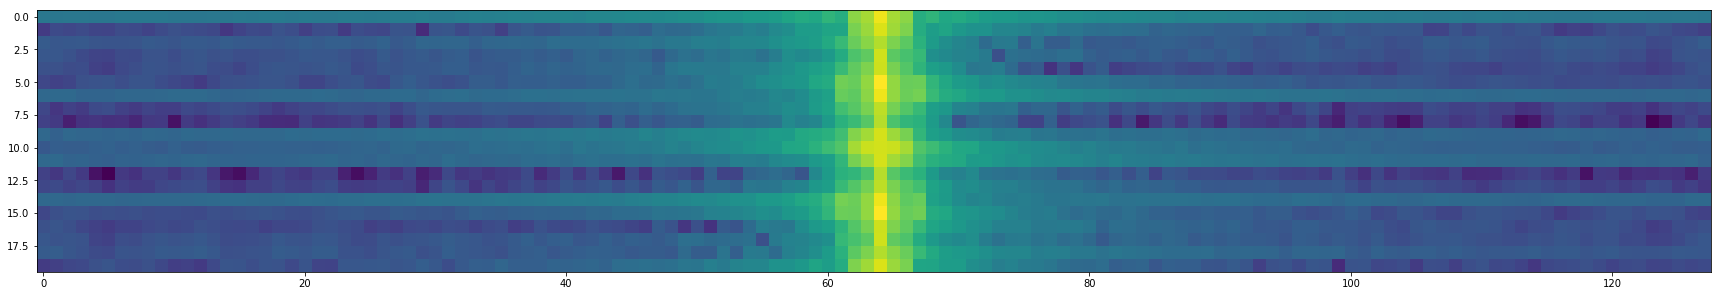

Activity:  9


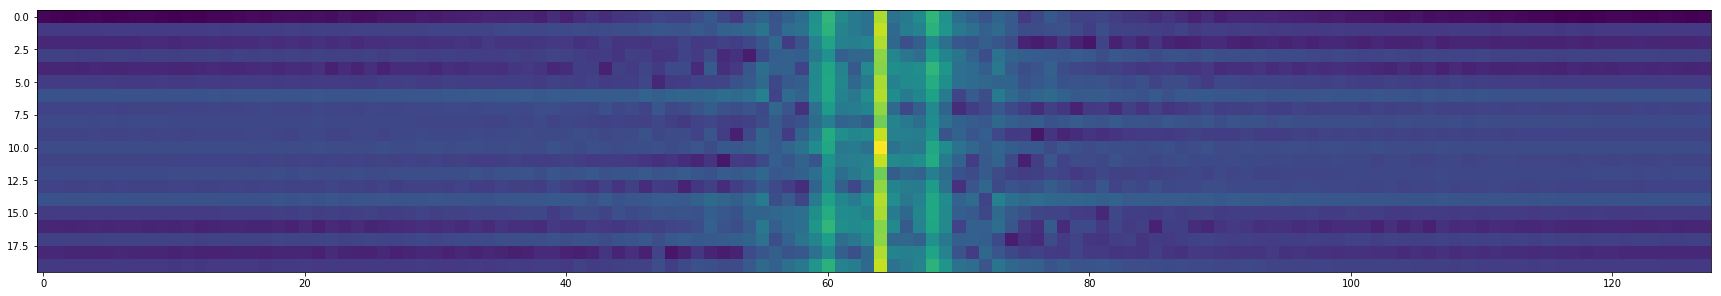

Activity:  24
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 128, 40)       1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 20)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 20)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 5)         0       

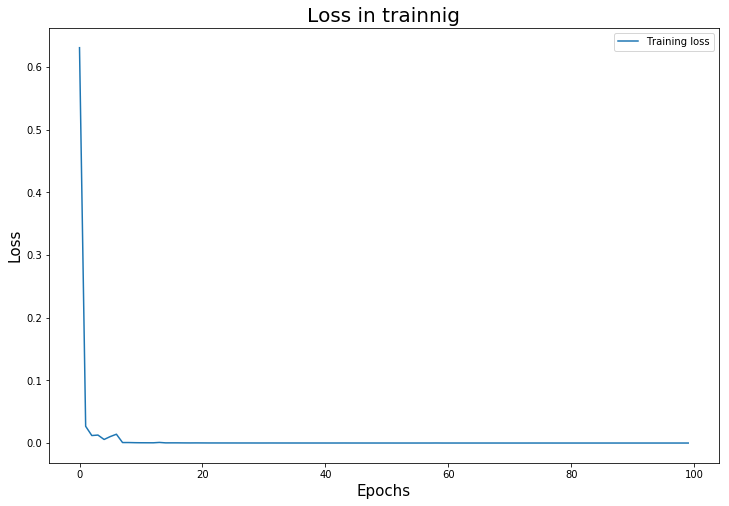

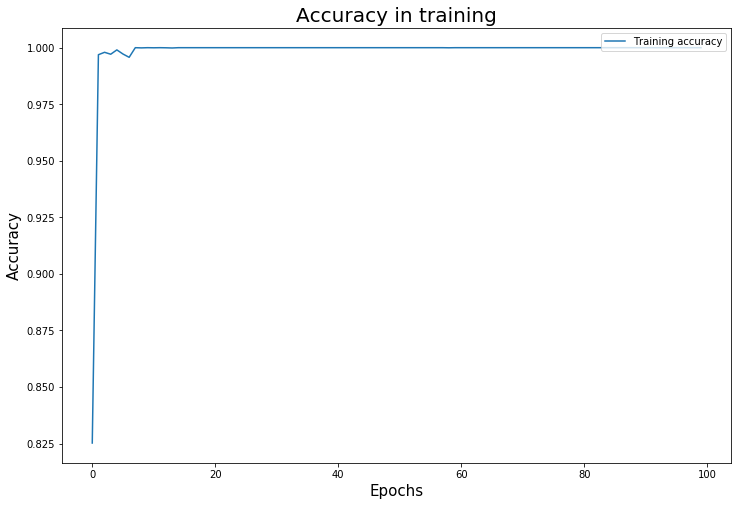

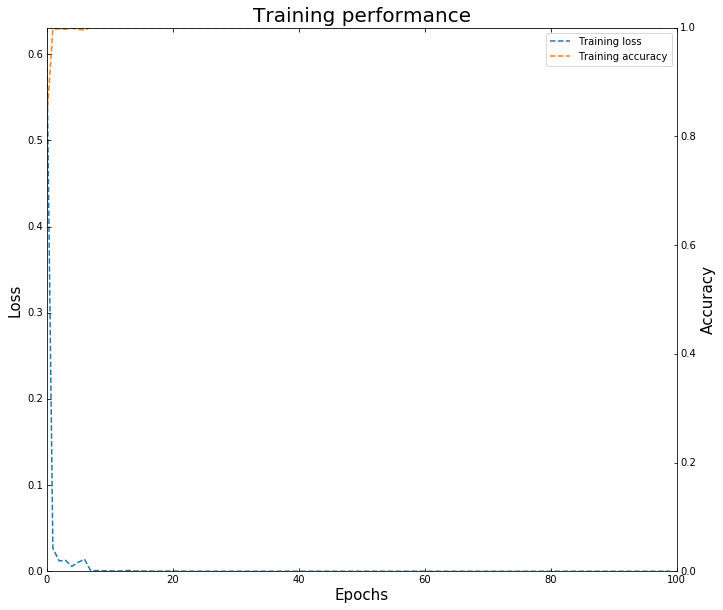

2613/2613 [==============================] - 1s 296us/sample
(2613, 11)
[[ 6  1  2  8  6  6  0  4  9  8  2  5  4  1  7  3 10  7  9  9  7  5  0  5
   3  0  8  7  9  3  1  5  0  9  5  9  2  8  6  5  5  9  8  0  1  2  8  5
   7  8 10  6  4  4  3 10  4  5  5  2  1  0  5  3  3  9  1  2 10 10  2  0
   7  0 10  9  8  9  4  0  4  8  0  2  2  0  4 10  9  3  2  3  7 10  5  7
   2  5  9  9]]
(2613, 1)
[[ 6  1  2  8  6  6  0  4  9  8  2  6  4  1  7  3 10  7  9  9  7  6  0  6
   3  0  8  7  9  3  1  6  0  9  5  9  2  8  6  5  6  9  8  0  1  2  8  5
   7  8 10  6  4  4  3 10  4  6  5  2  1  0  5  3  3  9  1  2 10 10  2  0
   7  0 10  9  8  9  4  0  4  8  0  2  2  0  4 10  9  3  2  1  7 10  5  7
   2  5  9  9]]
2613/2613 [==============================] - 1s 309us/sample - loss: 0.4095 - categorical_accuracy: 0.9480


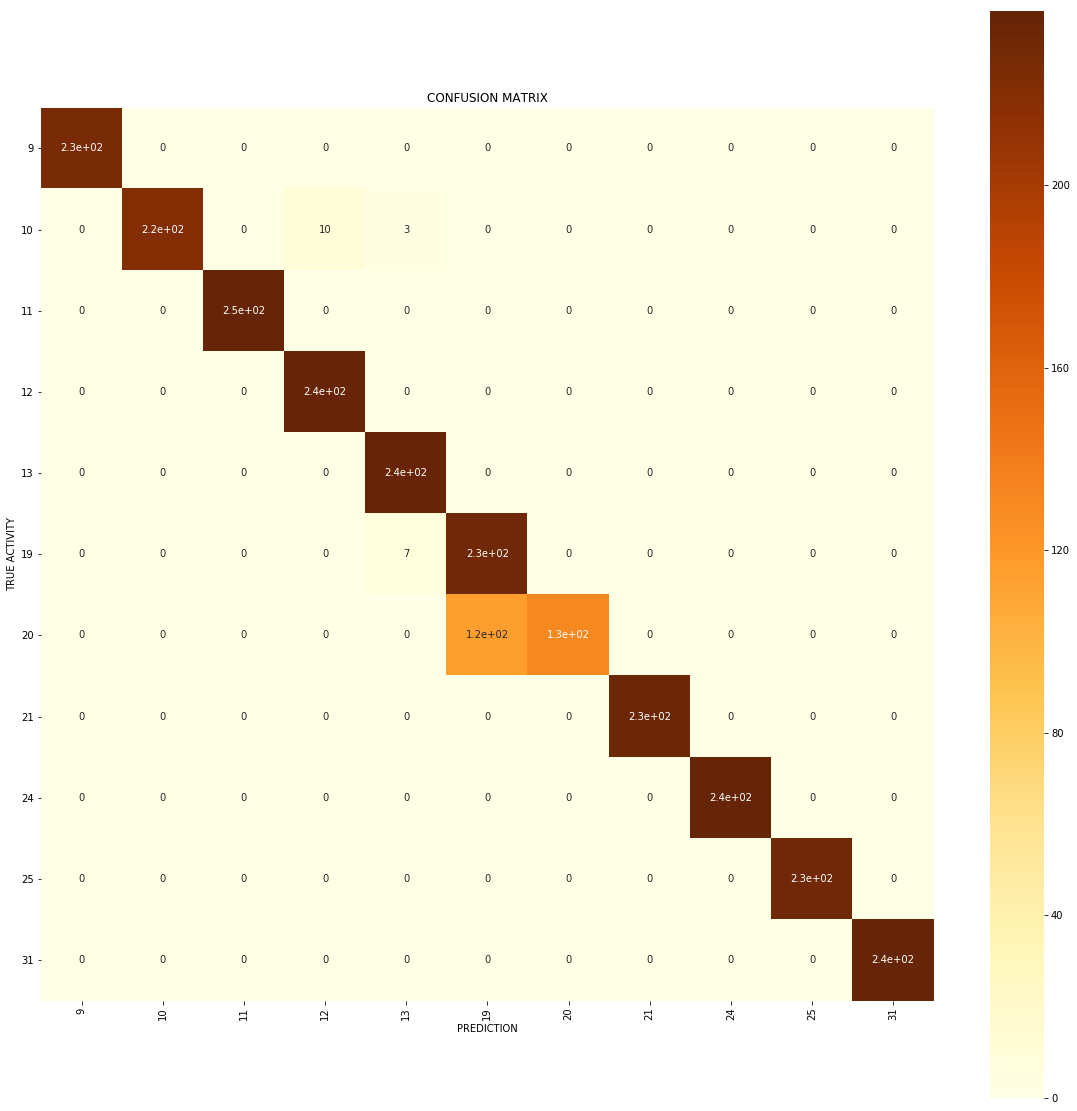

##################################################################################################################################
#####################################################  K-FOLD 2  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


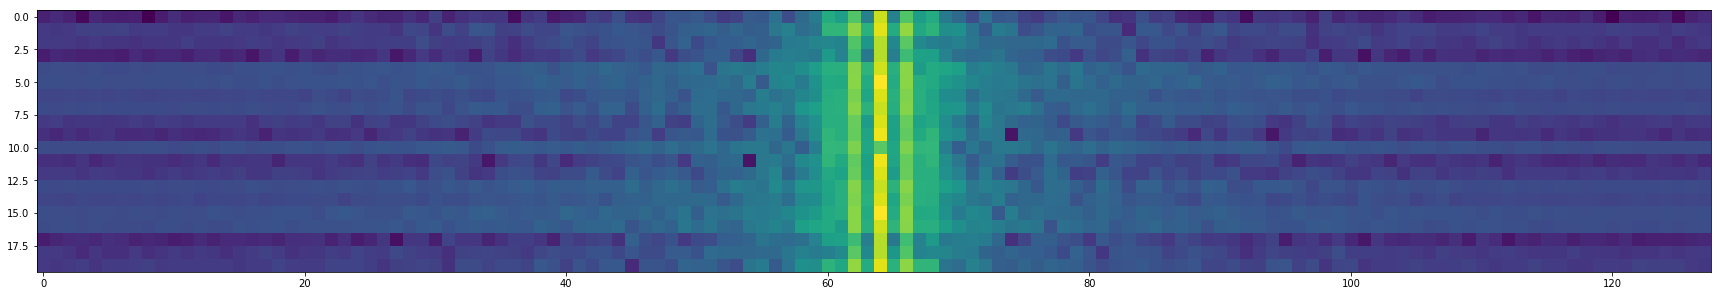

Activity:  20


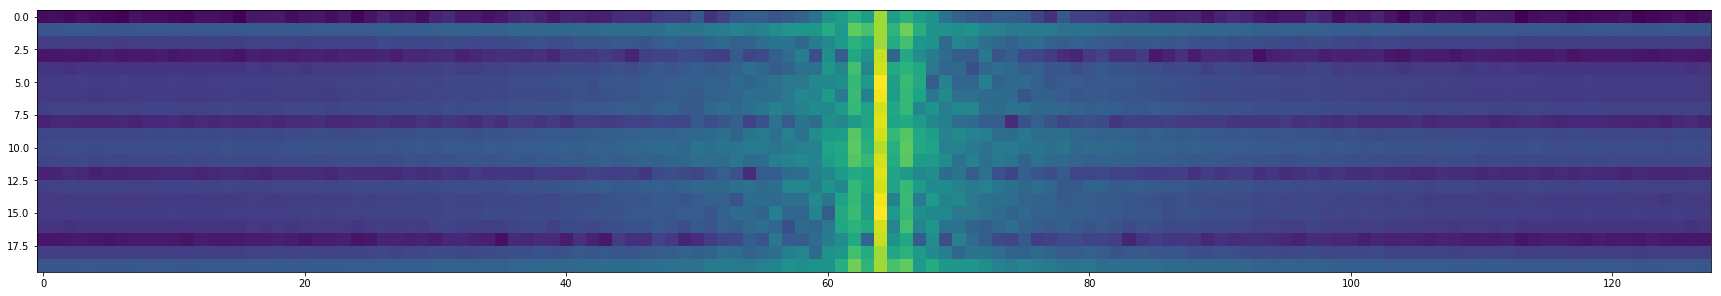

Activity:  11
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 128, 40)       1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 20)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 20)        65600     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 16, 5)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 16, 5)   

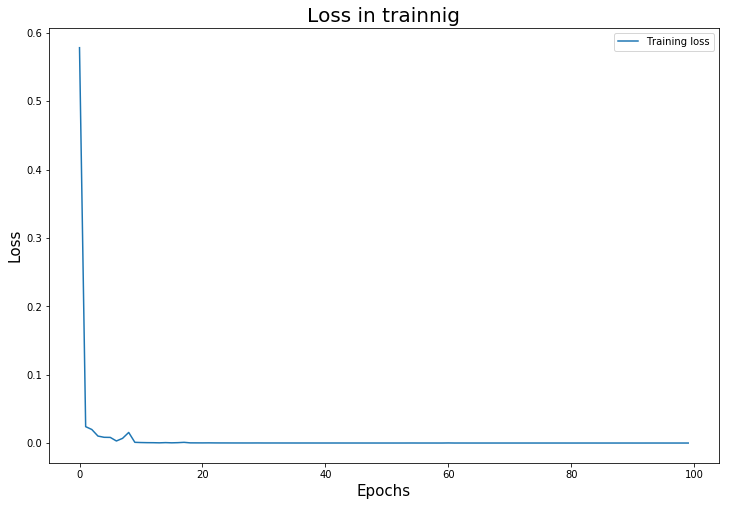

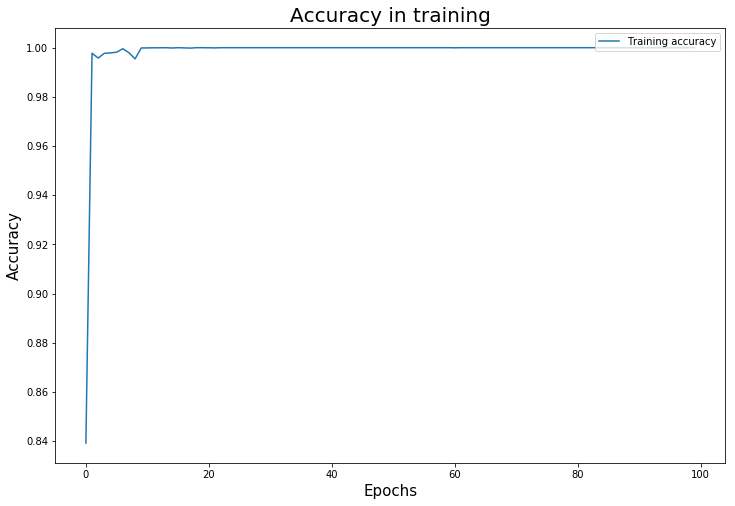

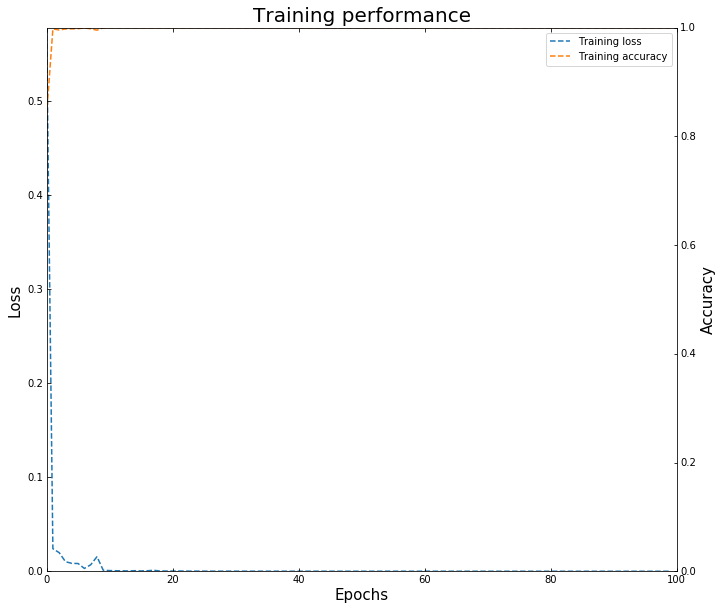

2613/2613 [==============================] - 1s 265us/sample
(2613, 11)
[[ 0  4  0  3  5 10  1  3  9  2  8  7  5  9  9  0  5  5  8  3  8  0  2  1
  10  1  5  6  4  5  8  2  8  9  7  4  0  9  4  7 10  7  4 10 10  5 10  4
   3  7  6  9  1  4  6  8  1  4  3  6 10  9  2  2  2  3  5  1  2  3  2  9
  10  2  3  4  1  8  9  2  5  2  9  5  8  0  6  1  0  7  2  6  6  0  3 10
   1  8  7  1]]
(2613, 1)
[[ 0  4  0  3  5 10  1  3  9  2  8  7  5  9  9  0  5  5  8  3  8  0  2  1
  10  1  5  6  4  5  8  2  8  9  7  4  0  9  4  7 10  7  4 10 10  5 10  4
   3  7  6  9  1  4  6  8  1  4  3  6 10  9  2  2  2  3  5  1  2  3  2  9
  10  2  3  4  1  8  9  2  5  2  9  5  8  0  6  1  0  7  2  6  6  0  3 10
   1  8  7  1]]
2613/2613 [==============================] - 1s 279us/sample - loss: 3.5142e-05 - categorical_accuracy: 1.0000


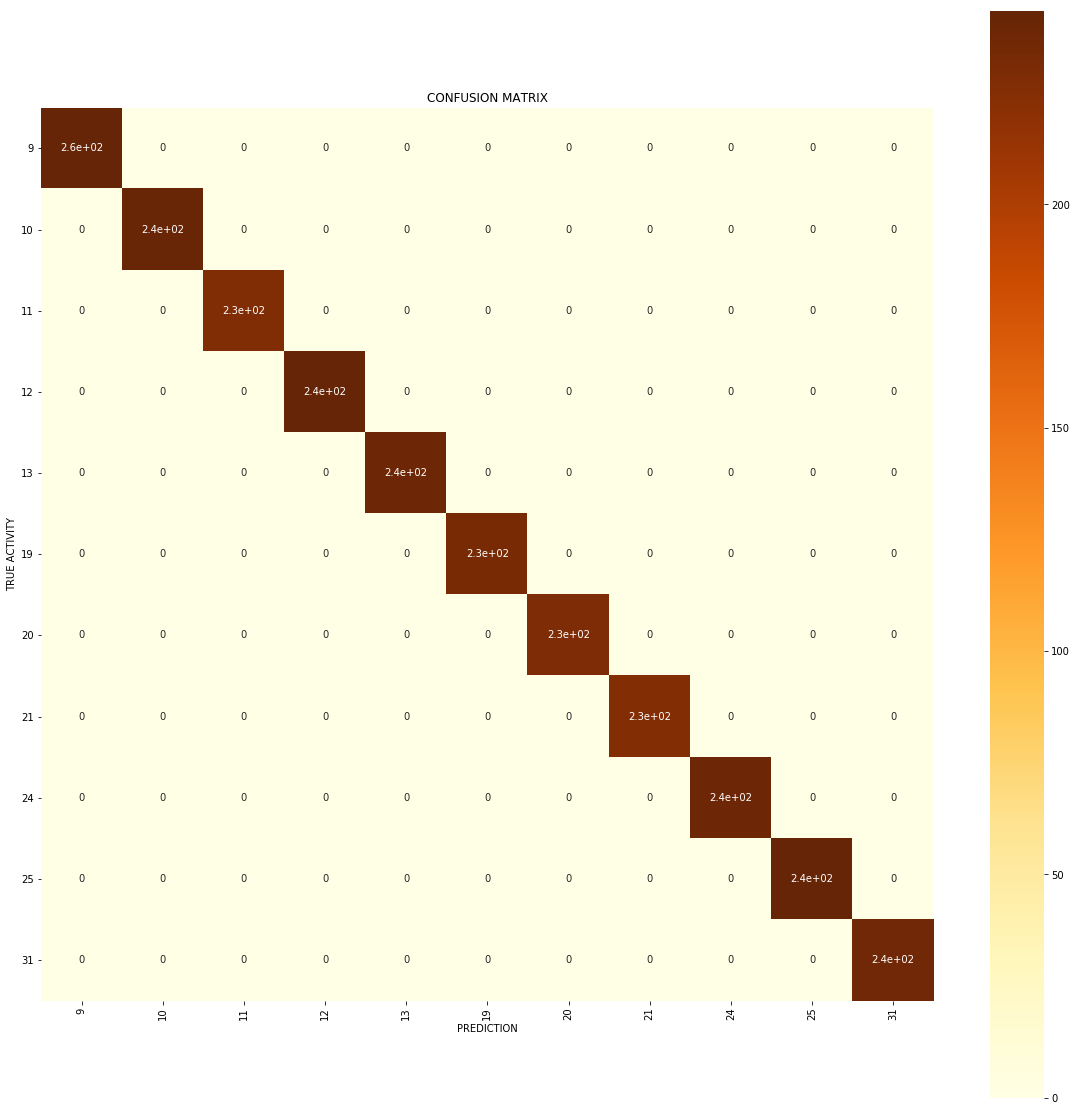

##################################################################################################################################
#####################################################  K-FOLD 3  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


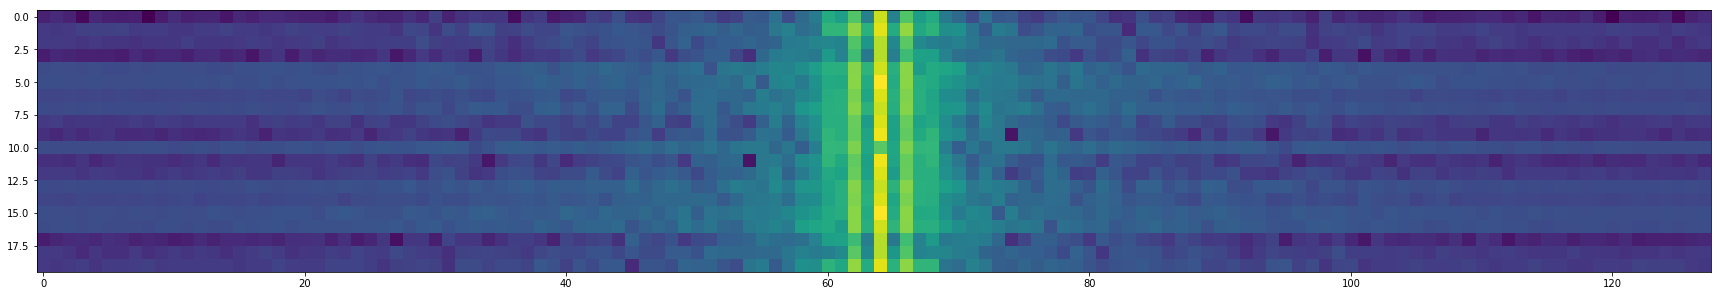

Activity:  20


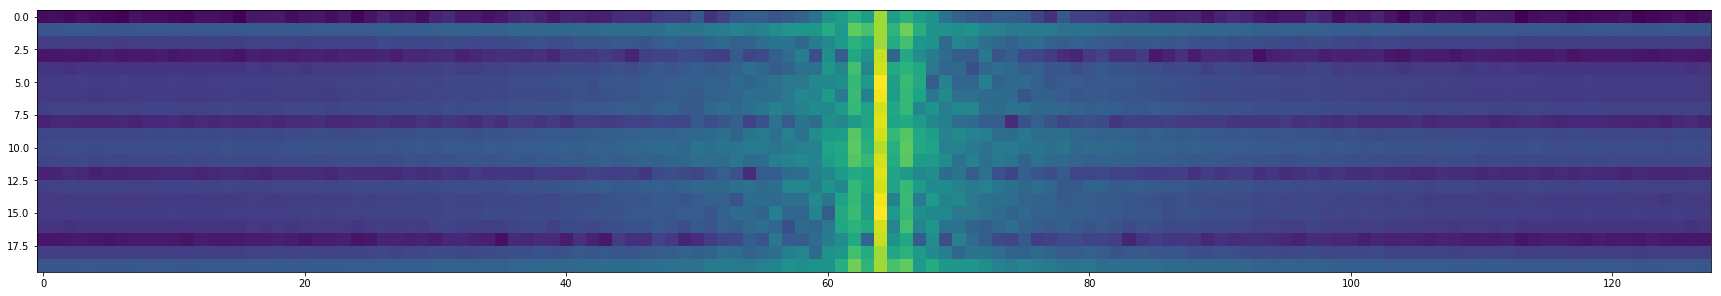

Activity:  11
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 128, 40)       1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 20)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 20)        65600     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 16, 5)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 16, 5)   

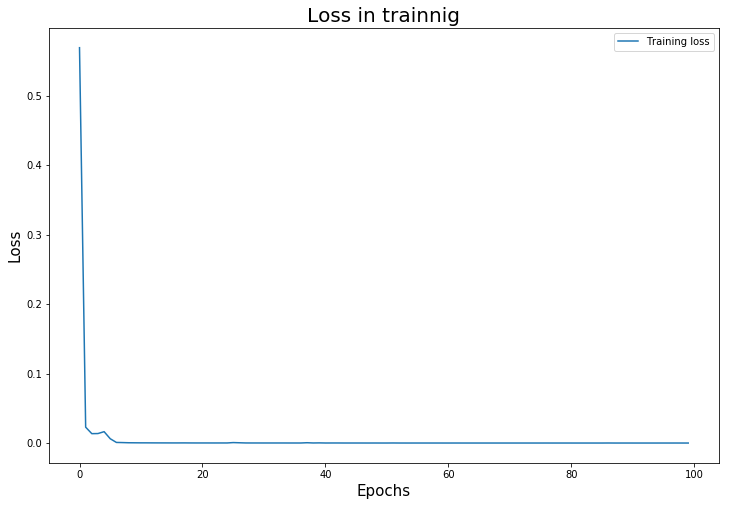

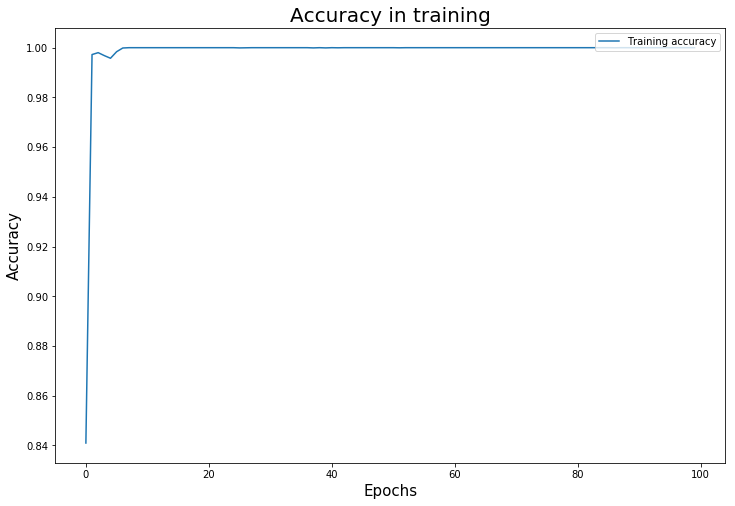

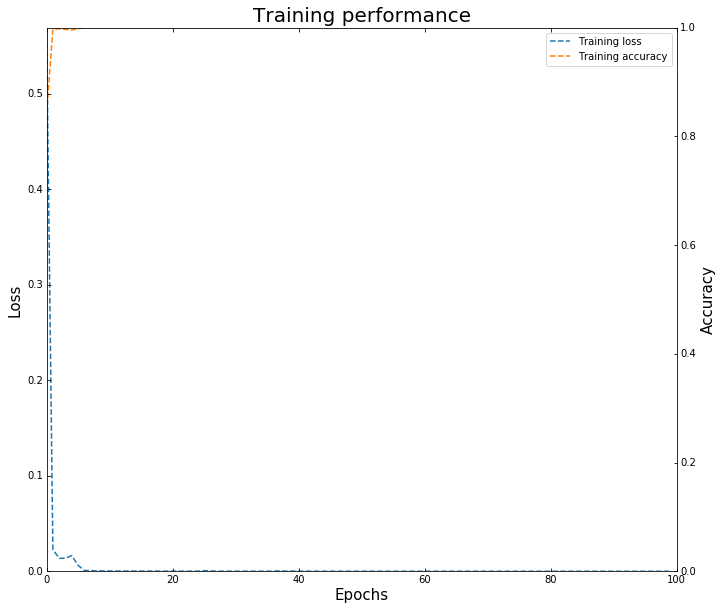

2613/2613 [==============================] - 1s 280us/sample
(2613, 11)
[[10  6  1 10  0 10  4  3  2  9  8  4  5  5  5  0  6  6  0  4  3  9  3  7
   0  1  4  5 10  5  9  1  1  9  4  6  1  3  0 10  4  6  3 10  7  1  9  1
  10  0  1  2  1  5  9  4  9  5  4  9  3  7  7 10  0  7  2 10  0  7  0  2
   1  6  7  1  9  6  6  4  3  4  7  9 10  8  2  0  8  7  6  8  5  1  6  5
   4  0  3  4]]
(2613, 1)
[[10  6  1 10  0 10  4  3  2  9  8  4  5  5  5  0  6  6  0  4  3  9  3  7
   0  1  4  5 10  5  9  1  1  9  4  6  1  3  0 10  4  6  3 10  7  1  9  1
  10  0  1  2  1  5  9  4  9  5  4  9  3  7  7 10  0  7  2 10  0  7  0  2
   1  6  7  1  9  6  6  4  3  4  7  9 10  8  2  0  8  7  6  8  5  1  6  5
   4  0  3  4]]
2613/2613 [==============================] - 1s 291us/sample - loss: 2.4381e-05 - categorical_accuracy: 1.0000


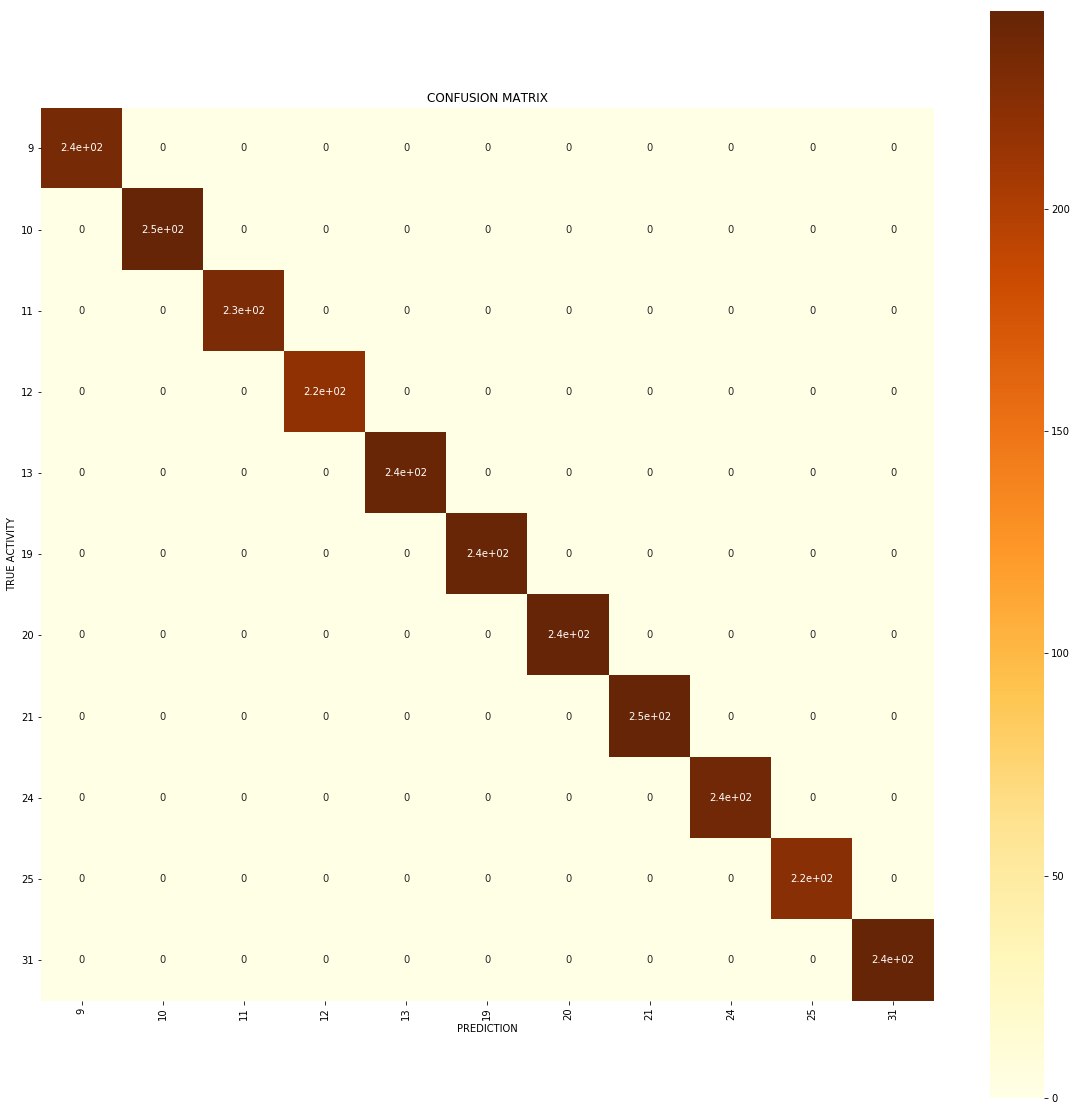

##################################################################################################################################
#####################################################  K-FOLD 4  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


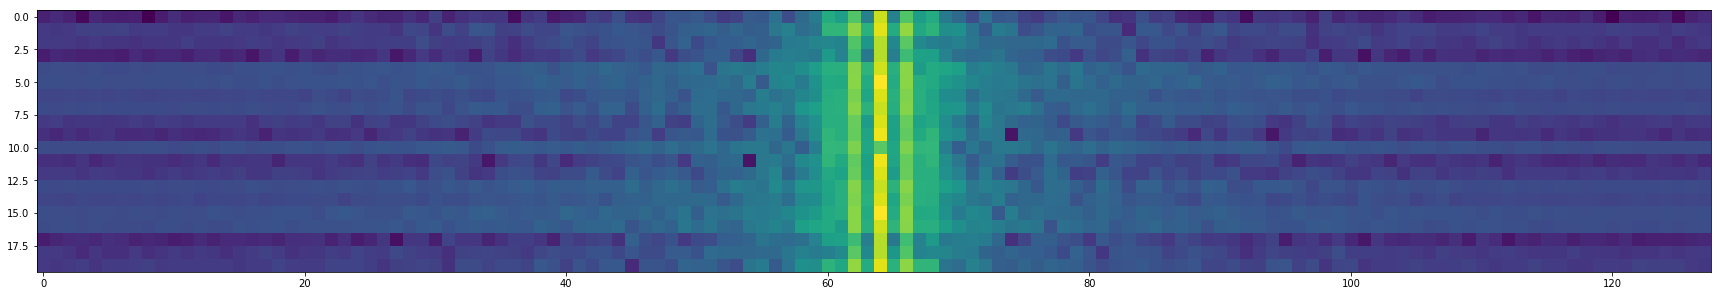

Activity:  20


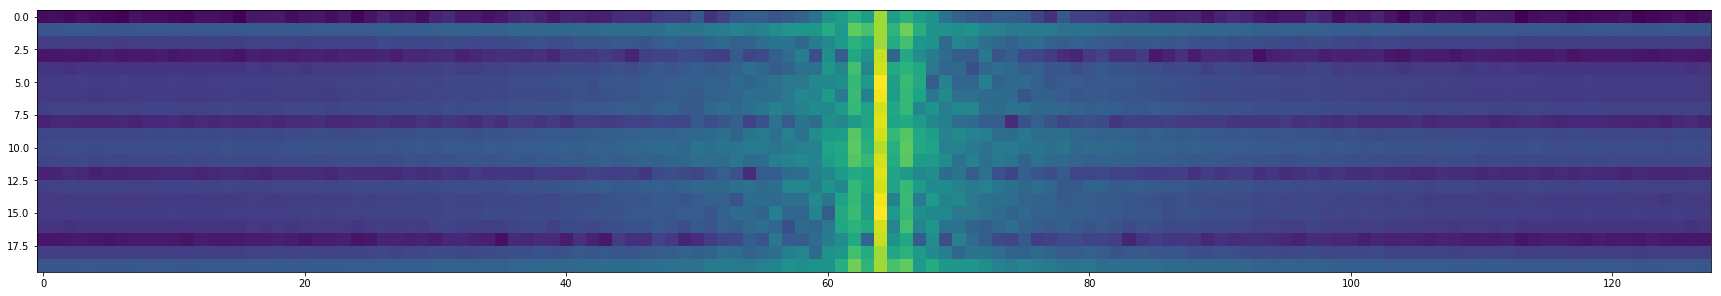

Activity:  11
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 128, 40)       1088      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 20)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 20)        65600     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 16, 5)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 16, 5)   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23512/23512 [==============================] - 13s 547us/sample - loss: 3.9243e-04 - categorical_accuracy: 1.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 21/100
23512/23512 [==============================] - 13s 549us/sample - loss: 3.1507e-04 - categorical_accuracy: 1.0000

Epoch 00022: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 22/100
23512/23512 [==============================] - 13s 547us/sample - loss: 5.9899e-04 - categorical_accuracy: 0.9999

Epoch 00023: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 23/100
23512/23512 [==============================] - 13s 550us/sample - loss: 2.2969e-04 - categorical_accuracy: 1.0000

Epoch 00024: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 24/100
23512/23512 [==============================] - 13s 548us/sample - loss: 2.1624e-04 - categorical_accuracy: 1.0000

Epoch 00025: LearningRateSchedule

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23512/23512 [==============================] - 13s 548us/sample - loss: 6.8859e-05 - categorical_accuracy: 1.0000

Epoch 00057: LearningRateScheduler reducing learning rate to 1.0240000000000004e-05.
Epoch 57/100
23512/23512 [==============================] - 13s 548us/sample - loss: 6.6804e-05 - categorical_accuracy: 1.0000

Epoch 00058: LearningRateScheduler reducing learning rate to 1.0240000000000004e-05.
Epoch 58/100
23512/23512 [==============================] - 13s 549us/sample - loss: 6.7769e-05 - categorical_accuracy: 1.0000

Epoch 00059: LearningRateScheduler reducing learning rate to 1.0240000000000004e-05.
Epoch 59/100
23512/23512 [==============================] - 13s 550us/sample - loss: 6.5735e-05 - categorical_accuracy: 1.0000

Epoch 00060: LearningRateScheduler reducing learning rate to 4.096000000000002e-06.
Epoch 60/100
23512/23512 [==============================] - 13s 548us/sample - loss: 6.3469e-05 - categorical_accuracy: 1.0000

Epoch 00061: LearningRateScheduler

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23512/23512 [==============================] - 13s 547us/sample - loss: 5.7834e-05 - categorical_accuracy: 1.0000

Epoch 00090: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 90/100
23512/23512 [==============================] - 13s 547us/sample - loss: 5.2881e-05 - categorical_accuracy: 1.0000

Epoch 00091: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 91/100
23512/23512 [==============================] - 13s 547us/sample - loss: 5.1989e-05 - categorical_accuracy: 1.0000

Epoch 00092: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 92/100
23512/23512 [==============================] - 13s 547us/sample - loss: 5.1129e-05 - categorical_accuracy: 1.0000

Epoch 00093: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 93/100
23512/23512 [==============================] - 13s 547us/sample - loss: 6.2377e-05 - categorical_accuracy: 1.0000

Epoch 00094: LearningRateSchedule

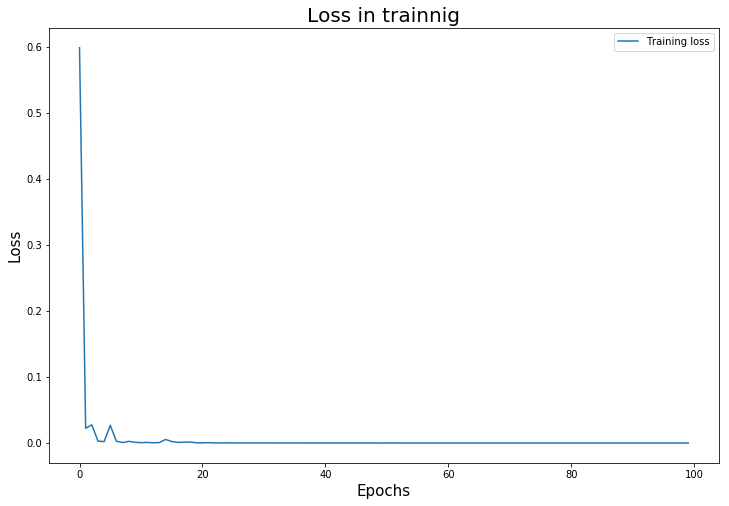

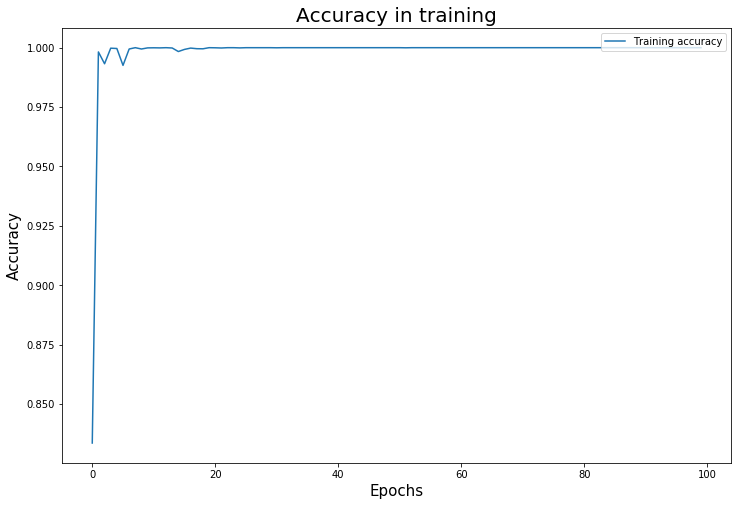

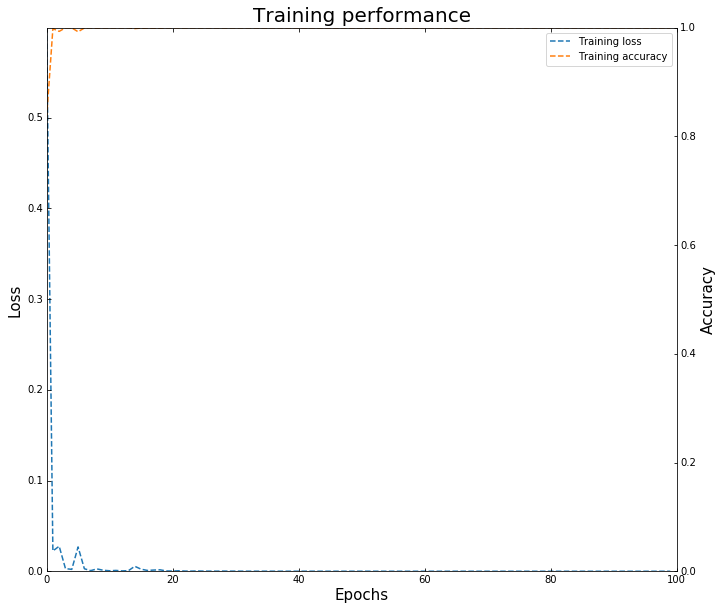

2613/2613 [==============================] - 1s 294us/sample
(2613, 11)
[[ 4  9  5  2  5  8  6 10 10  2  0  0  1  7  8  4  8  0  7  4  6  0 10  3
   8  5  4  9 10  6  1 10  3  0  6  0  7  2  8 10  2  5 10  8  5  7  3  4
   0  9  6  2  9  7  2  8  1  9  5  9 10  1  0  2  6  2  7  2  3  8  6  5
   2  9  0 10  5  4  2  2  2  3  3 10  0  8  4  1  9  5  7 10  4  1  7  8
   5  6  6  9]]
(2613, 1)
[[ 4  9  5  2  5  8  6 10 10  2  0  0  1  7  8  4  8  0  7  4  6  0 10  3
   8  5  4  9 10  6  1 10  3  0  6  0  7  2  8 10  2  5 10  8  5  7  3  4
   0  9  6  2  9  7  2  8  1  9  5  9 10  1  0  2  6  2  7  2  3  8  6  5
   2  9  0 10  5  4  2  2  2  3  3 10  0  8  4  1  9  5  7 10  4  1  7  8
   5  6  6  9]]
2613/2613 [==============================] - 1s 306us/sample - loss: 2.1997e-05 - categorical_accuracy: 1.0000


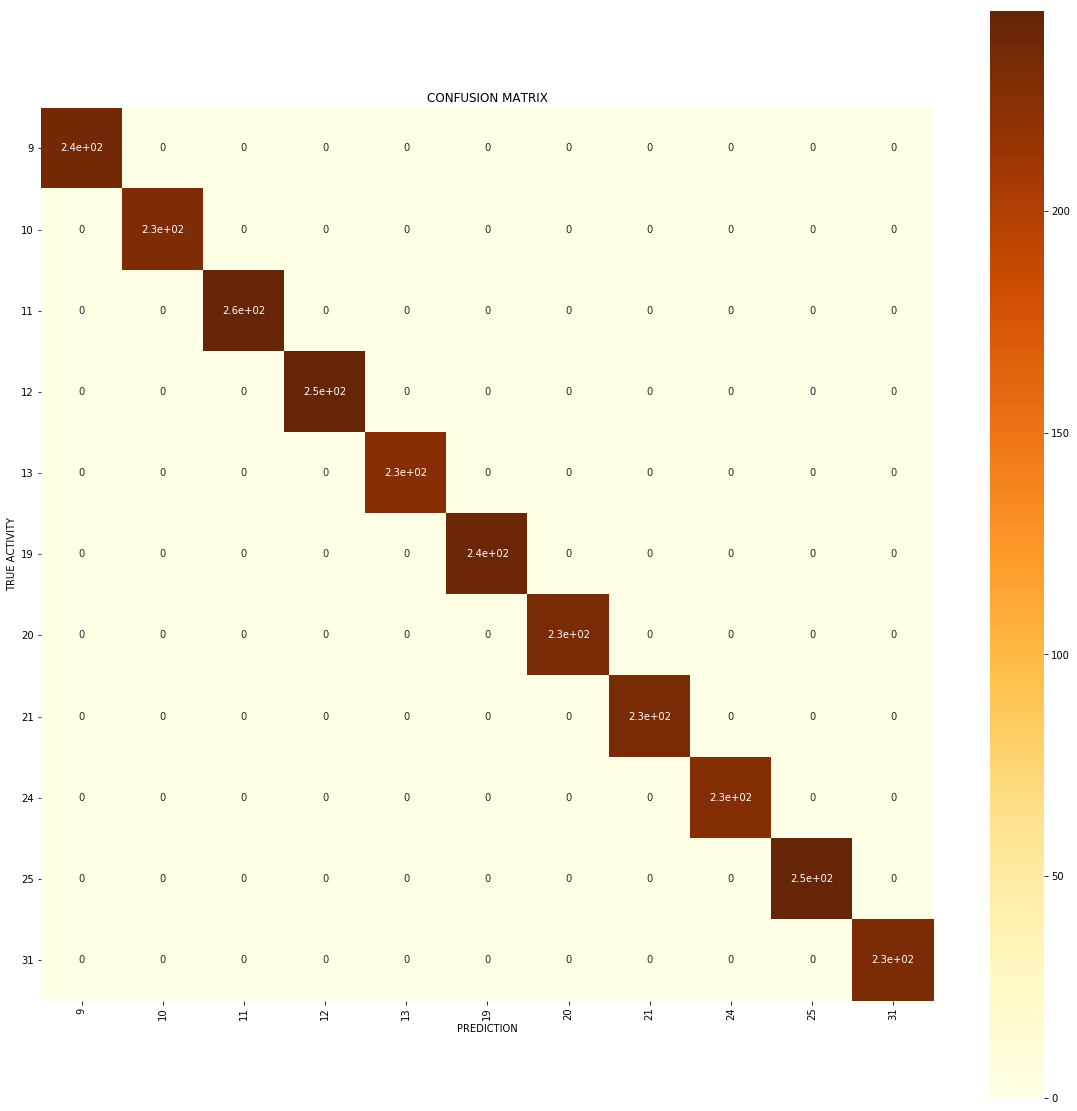

##################################################################################################################################
#####################################################  K-FOLD 5  ################################################################
Train dataset: 
(23512, 1, 128, 40) (23512, 11)
Test dataset: 
(2613, 1, 128, 40) (2613, 11)


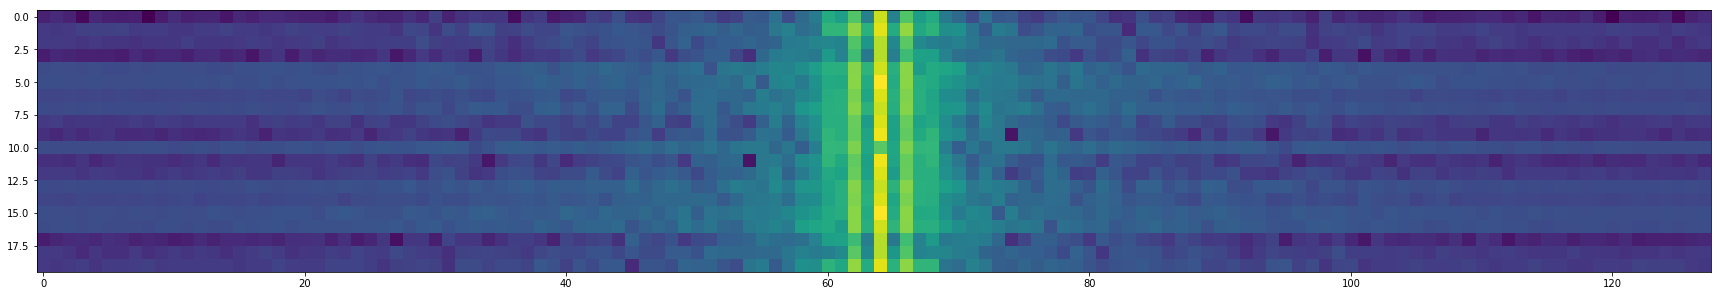

Activity:  20


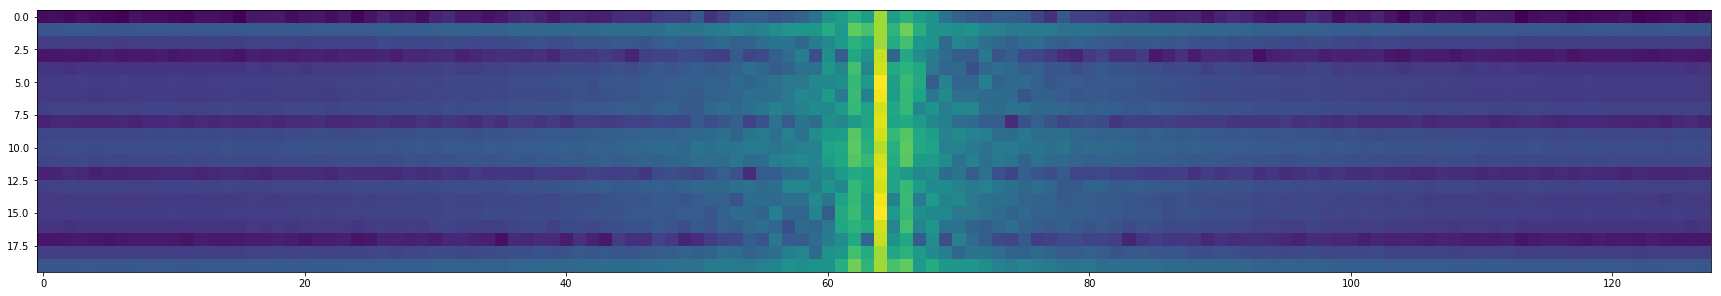

Activity:  11
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 128, 40)       1088      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 64, 20)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 20)        65600     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 16, 5)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 16, 5)   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23512/23512 [==============================] - 13s 552us/sample - loss: 6.4750e-04 - categorical_accuracy: 0.9998

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 26/100
23512/23512 [==============================] - 13s 552us/sample - loss: 7.5976e-04 - categorical_accuracy: 0.9998

Epoch 00027: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 27/100
23512/23512 [==============================] - 13s 552us/sample - loss: 2.3122e-04 - categorical_accuracy: 1.0000

Epoch 00028: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 28/100
23512/23512 [==============================] - 13s 552us/sample - loss: 1.6335e-04 - categorical_accuracy: 1.0000

Epoch 00029: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 29/100
23512/23512 [==============================] - 13s 551us/sample - loss: 1.5651e-04 - categorical_accuracy: 1.0000

Epoch 00030: LearningRateSchedule

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23512/23512 [==============================] - 13s 553us/sample - loss: 6.8222e-05 - categorical_accuracy: 1.0000

Epoch 00061: LearningRateScheduler reducing learning rate to 4.096000000000002e-06.
Epoch 61/100
23512/23512 [==============================] - 13s 552us/sample - loss: 6.1958e-05 - categorical_accuracy: 1.0000

Epoch 00062: LearningRateScheduler reducing learning rate to 4.096000000000002e-06.
Epoch 62/100
23512/23512 [==============================] - 13s 552us/sample - loss: 6.0901e-05 - categorical_accuracy: 1.0000

Epoch 00063: LearningRateScheduler reducing learning rate to 4.096000000000002e-06.
Epoch 63/100
23512/23512 [==============================] - 13s 553us/sample - loss: 6.1405e-05 - categorical_accuracy: 1.0000

Epoch 00064: LearningRateScheduler reducing learning rate to 4.096000000000002e-06.
Epoch 64/100
23512/23512 [==============================] - 13s 552us/sample - loss: 6.3378e-05 - categorical_accuracy: 1.0000

Epoch 00065: LearningRateScheduler re

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23512/23512 [==============================] - 13s 552us/sample - loss: 9.1395e-05 - categorical_accuracy: 1.0000

Epoch 00094: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 94/100
23512/23512 [==============================] - 13s 552us/sample - loss: 5.7618e-05 - categorical_accuracy: 1.0000

Epoch 00095: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 95/100
23512/23512 [==============================] - 13s 553us/sample - loss: 5.3375e-05 - categorical_accuracy: 1.0000

Epoch 00096: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 96/100
23512/23512 [==============================] - 13s 552us/sample - loss: 5.5895e-05 - categorical_accuracy: 1.0000

Epoch 00097: LearningRateScheduler reducing learning rate to 2.6214400000000015e-07.
Epoch 97/100
23512/23512 [==============================] - 13s 551us/sample - loss: 5.5529e-05 - categorical_accuracy: 1.0000

Epoch 00098: LearningRateSchedule

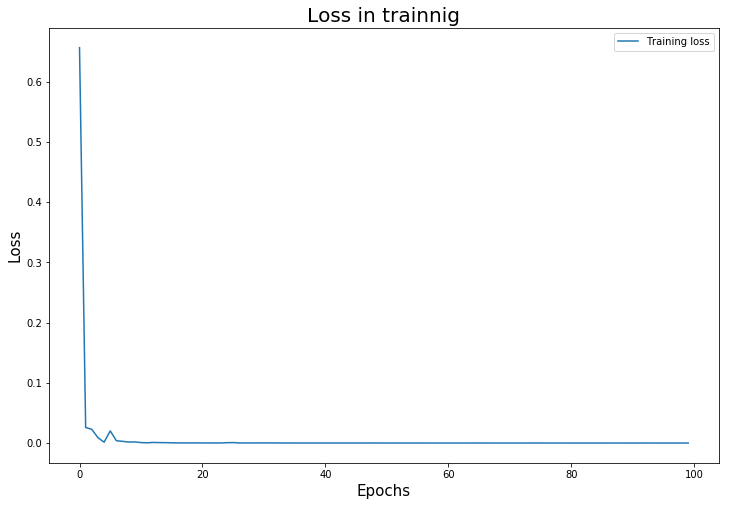

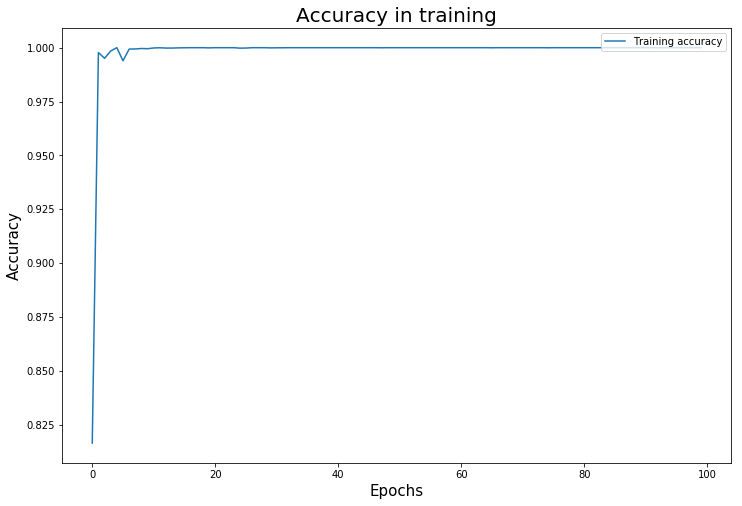

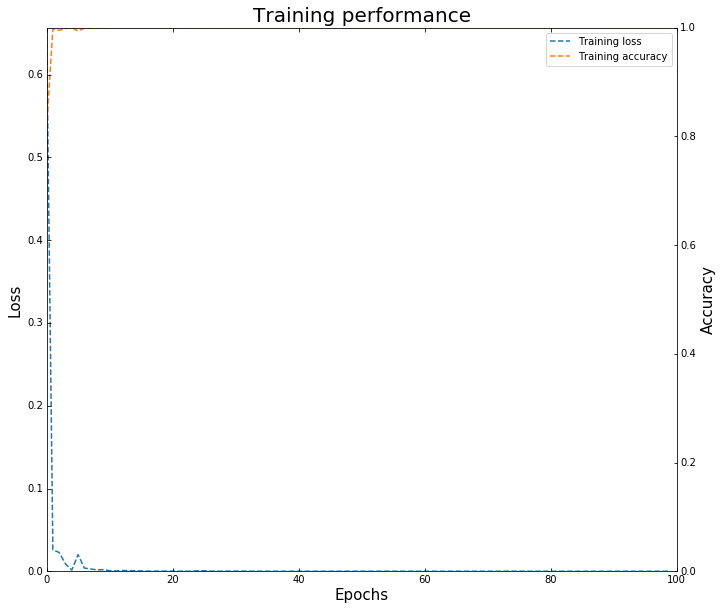

2613/2613 [==============================] - 1s 307us/sample
(2613, 11)
[[ 5  2  7  8  8 10  7  8  5  3  3  2  4  4  1  0  2  4  6  4 10 10  8  3
   0  8  0 10  4  5  6  7  6  8  8 10  6  1  0  6  0  0 10  3  6  7  2  0
   0  7  4  5  7  8  0  0 10  7  6  1  0  1  2  2  8  7  7  5  8  3  6  3
   0  1  5  5  7  3  5  2  3  5  0  6  2  8 10  3  7  8 10  2  1  8  2  2
   4  0  4  4]]
(2613, 1)
[[ 5  2  7  8  8 10  7  8  5  3  3  2  4  4  1  0  2  4  6  4 10 10  8  3
   0  8  0 10  4  5  6  7  6  8  8 10  6  1  0  6  0  0 10  3  6  7  2  0
   0  7  4  5  7  8  0  0 10  7  6  1  0  1  2  2  8  7  7  5  8  3  6  3
   0  1  5  5  7  3  5  2  3  5  0  6  2  8 10  3  7  8 10  2  1  8  2  2
   4  0  4  4]]
2613/2613 [==============================] - 1s 313us/sample - loss: 2.1070e-05 - categorical_accuracy: 1.0000


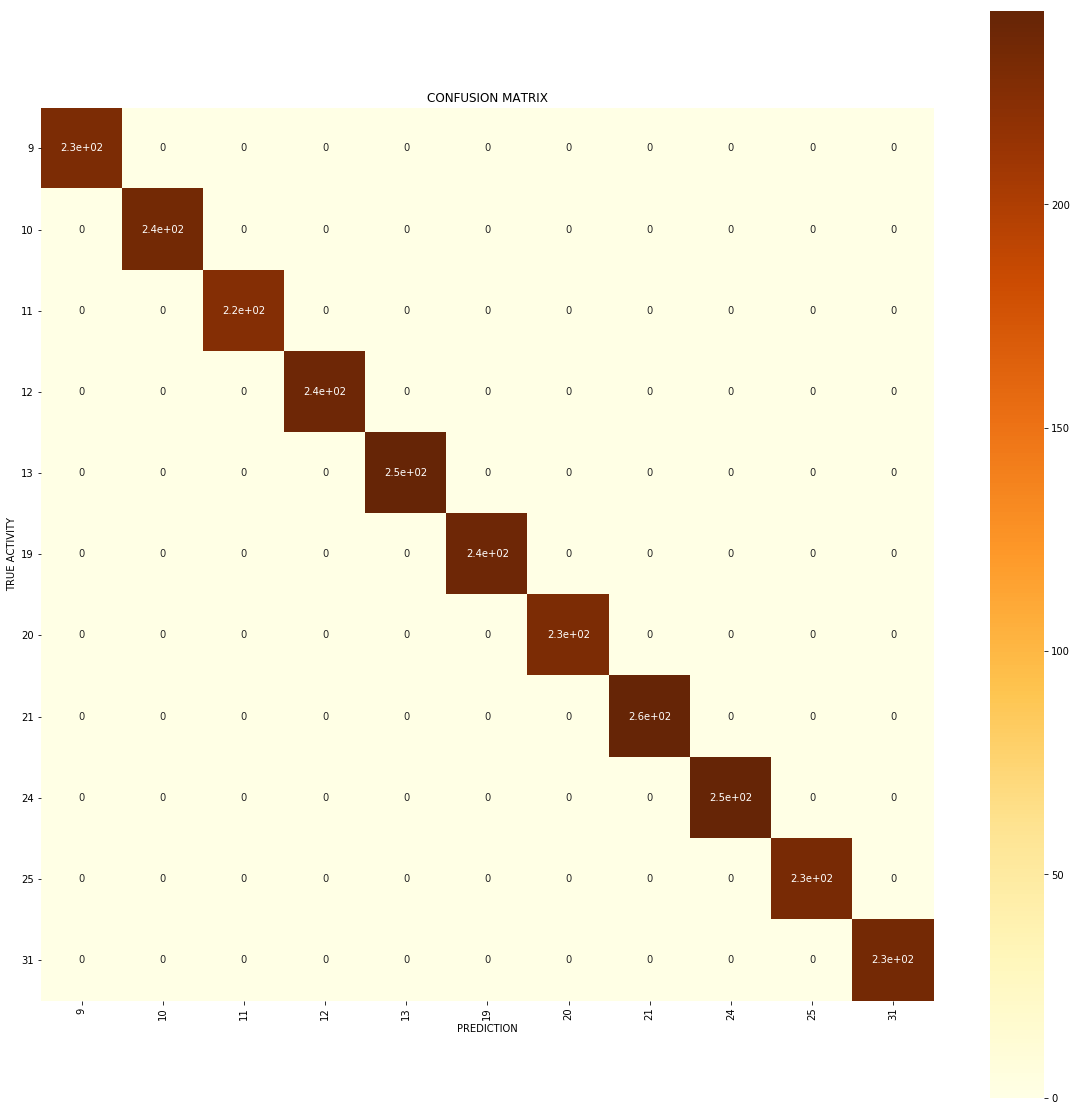

##################################################################################################################################
#####################################################  K-FOLD 6  ################################################################
Train dataset: 
(23513, 1, 128, 40) (23513, 11)
Test dataset: 
(2612, 1, 128, 40) (2612, 11)


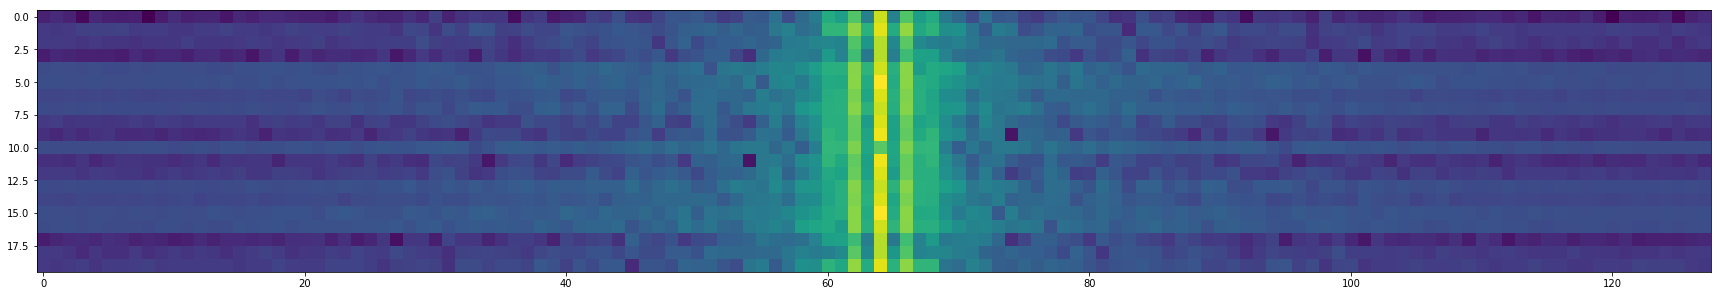

Activity:  20


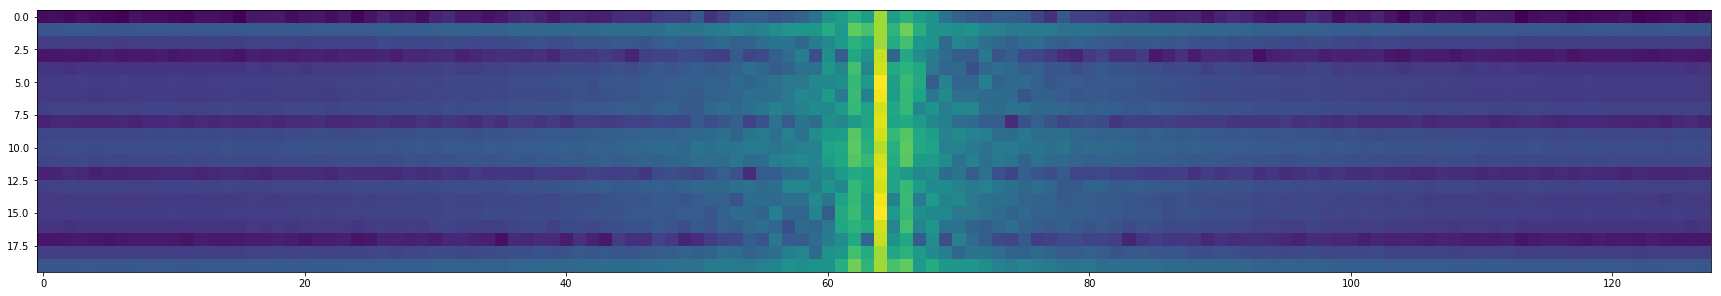

Activity:  11
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 40)]      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 128, 40)       1088      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 20)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 20)        65600     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 16, 5)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 16, 5)   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23513/23513 [==============================] - 13s 552us/sample - loss: 1.1924e-04 - categorical_accuracy: 1.0000

Epoch 00029: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 29/100
23513/23513 [==============================] - 13s 553us/sample - loss: 1.0662e-04 - categorical_accuracy: 1.0000

Epoch 00030: LearningRateScheduler reducing learning rate to 6.400000000000001e-05.
Epoch 30/100
23513/23513 [==============================] - 13s 552us/sample - loss: 1.1300e-04 - categorical_accuracy: 1.0000

Epoch 00031: LearningRateScheduler reducing learning rate to 6.400000000000001e-05.
Epoch 31/100
23513/23513 [==============================] - 13s 552us/sample - loss: 1.1713e-04 - categorical_accuracy: 1.0000

Epoch 00032: LearningRateScheduler reducing learning rate to 6.400000000000001e-05.
Epoch 32/100
23513/23513 [==============================] - 13s 553us/sample - loss: 9.5705e-05 - categorical_accuracy: 1.0000

Epoch 00033: LearningRateScheduler r

In [ ]:
accuracies = []
for i in range(10):
    if(i<10):
        kfold='0'+str(i)
    else:
        kfold=str(i)
    print('##################################################################################################################################')
    print('#####################################################  K-FOLD %d  ################################################################'%(i+1))
    
    subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
    
    ##  GENERACIÓN DATASET
    tr_seg = np.concatenate((np.load('./augment_2/subject_'+subjects[0]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[1]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[2]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[3]+'_seg.npy'),
                             np.load('./augment_2/subject_'+subjects[4]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[5]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[6]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[7]+'_seg.npy'),
                             np.load('./augment_2/subject_'+subjects[8]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[9]+'_seg.npy'),np.load('./augment_2/subject_'+subjects[10]+'_seg.npy')))

    tr_lab = np.concatenate((np.load('./augment_2/subject_'+subjects[0]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[1]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[2]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[3]+'_lab.npy'),
                             np.load('./augment_2/subject_'+subjects[4]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[5]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[6]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[7]+'_lab.npy'),
                             np.load('./augment_2/subject_'+subjects[8]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[9]+'_lab.npy'),np.load('./augment_2/subject_'+subjects[10]+'_lab.npy')))
    
    limit = 40
    tr_seg = tr_seg[:,:,:,:limit]
    ####################################################################################################################
    ## SHUFFLE DE DATOS
    np.random.seed(235)
    tr_seg = np.reshape(tr_seg[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,1,128,limit))
    tr_lab = np.reshape(tr_lab[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,11))
    
    ts_seg = tr_seg[S_test[i]]
    ts_lab = tr_lab[S_test[i]]
    
    tr_seg = tr_seg[S_train[i]]
    tr_lab = tr_lab[S_train[i]]
    
    print('Train dataset: ')
    print(tr_seg.shape, tr_lab.shape)
    print('Test dataset: ')
    print(ts_seg.shape, ts_lab.shape)
    ####################################################################################################################
    ## VISTA DE DFT-2D
    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.abs(np.fft.fftshift(tr_seg[0,0,:,20:40].T))**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[0])])

    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.fft.fftshift(tr_seg[10,0,:,20:40].T)**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[10])])
    ####################################################################################################################
    ## RED
    quat_input = keras.Input(shape=(n_channels, n_time_steps, n_columns), name='input_layer')

    # Some convolutional layers
    conv_1 = keras.layers.Conv2D(64, kernel_size=4,padding='same',activation='relu', data_format = 'channels_first')(quat_input)
    max_1 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_1)
    bn_1 = keras.layers.BatchNormalization(axis=1)(max_1)
    conv_2 = keras.layers.Conv2D(64,kernel_size=4, padding='same',activation='relu', data_format = 'channels_first')(bn_1)
    max_2 = keras.layers.MaxPooling2D(pool_size=4, strides=4, padding='same', data_format = 'channels_first')(conv_2)
    bn_2 = keras.layers.BatchNormalization(axis=1)(max_2)
    conv_3 = keras.layers.Conv2D(64,kernel_size=4, padding='same',activation='relu', data_format = 'channels_first')(bn_2)
    max_3 = keras.layers.MaxPooling2D(pool_size=4, strides=4, padding='same', data_format = 'channels_first')(conv_3)
    bn_3 = keras.layers.BatchNormalization(axis=1)(max_3)

    # Flatten the output of the convolutional layers
    #conv_flat = keras.layers.Flatten()(max_3)
    dr_1 = keras.layers.Dropout(0.5)(bn_3)

    units = 64

    res_1 = keras.layers.Reshape((8,units))(dr_1)

    gru_1 = keras.layers.GRU(units, activation='tanh', return_sequences=False, reset_after = False)(res_1)
    
    # Output layers: separate outputs for the weather and the ground labels
    multiclass_output = keras.layers.Dense(n_classes, activation='softmax',name='activity_class')(gru_1)
    
    # Creamos la estrcutura que contendrá a nuestro modelo
    model = keras.Model(inputs=quat_input, outputs=[multiclass_output],name='cnn')

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    print(model.summary())
    ####################################################################################################################
    ## TRAIN
    history = model.fit(tr_seg,
                        tr_lab,
                        epochs = epochs,
                        steps_per_epoch = None,
                        verbose = 1,
                        batch_size = batch_size,
                        callbacks = callbacks_list)
    model.save('./02BAUGFFT_RP_KFOLD_models/CNN_'+kfold+'.h5')
    
    #Visualize training evolution
    plot_curves(model, 'categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', kfold)
    ####################################################################################################################
    ## TEST
    predictions = model.predict(ts_seg, batch_size = batch_size, verbose = 1)
    
    print(predictions.shape)
    
    y_pred = np.argmax(predictions,axis=-1)
    y_pred = np.expand_dims(y_pred,axis=-1)
    print(y_pred[:100].T)
    
    y_true = np.argmax(ts_lab,axis=-1)
    y_true = np.expand_dims(y_true,axis=-1)
    print(y_true.shape)
    print(y_true[:100].T)
    
    evaluation = model.evaluate(ts_seg, ts_lab, batch_size=batch_size, verbose=1)
    accuracies.append(evaluation[1])
    
    fo = open('./02BAUGFFT_RP_KFOLD_models/accuracy_'+kfold+'.txt', "w")
    fo.seek(0,2)
    fo.write(str(evaluation))
    fo.close()
    
    ####################################################################################################################
    ## CONFUSION MATRIX
    y_true_flat = np.ndarray.flatten(y_true)
    y_pred_flat = np.ndarray.flatten(y_pred)
    
    plot_confusion_matrix(y_true_flat, y_pred_flat, kfold, classes=activities)
    
    del kfold, limit, tr_seg, tr_lab, ts_seg, ts_lab, model, history, y_pred, y_true, predictions, evaluation, y_true_flat, y_pred_flat
    

# Accuracy

In [14]:
sum = 0
for acc in accuracies:
    sum += acc
print('Accuracy of K-Fold: ' + str(sum/10))

Accuracy of K-Fold: 0.9947186887264252
